# GENERATİVE ADVERSARİAL NETWORKS

### KAYNAKLAR

https://arxiv.org/pdf/1406.2661.pdf      Generative Adversarial Nets

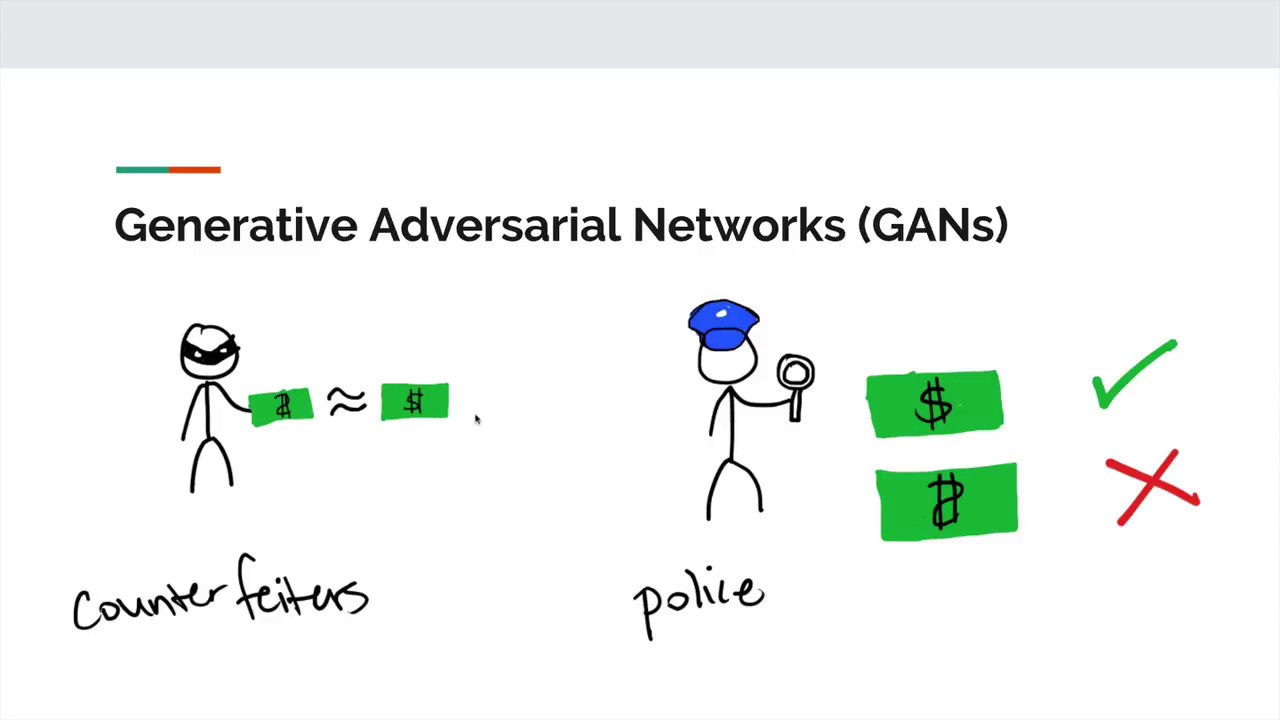

### GANs nedir ? 

Generative Adversarial Networks, kısaca GANs yapısında bulunan iki farklı modelin birbirini geliştirmesi sonucu eğitilen modellerin çıktı olarak sentetik veri vermesini sağlar. Bu "veri" olarak adlandırdığımız ürün günümüzde karşımıza en çok "DeepFake" olarak adlandırılan ünlü kişilerin hiç var olmayan sentetik video&ses&fotoğraf ürünleri olarak karşımıza çıkar.

### GANs nasıl çalışır ? 

GANs klasik deep neural networks'den farklı olarak iki adet ağ içerir. Bunlar "generative"(Üretken)(G) ve "discriminative"(ayrımcı)(D) olmak üzere ikiye ayrılır. Generative model verinin dağılımını yakalamaya çalışır, discriminative model ise kendisine gelen verinin generative modelde üretilmek üzere yakalanan veri dağılımından oluşan sentetik bir veri mi yoksa generative modelin yakalamaya çalıştığı orjinal veri mi olduğunun olasılığını hesaplar.

### Hırsız - polis metaforu ile GANs

Yukarıdaki resimde gösterilen metafor üzerinden devam edelim. Bizim generative modelimizi sahte para basmaya çalışan bir dolandırıcı, discriminative modelimizi ise bu paranın sahte mi gerçek mi olduğunu tespit etmeye çalışan polis olarak değerlendirelim. Dolandırıcı sahte para üretmeyi dener ve başlangıçta deneyimsizdir, başarısız taklitler ortaya koyar. Polis ise paranın sahte olduğunu tespit eder.  Dolandırıcı tekrar sahte para üretmeyi dener , bu sefer polis ayırt etmekte zorlanır fakat sahte olduğunu anlar. Dolandırıcı polisin farkettiği pürüzleri temizler, polis her seferinde daha dikkatli inceler. Belli bir aşamadan sonra dolandırıcı da polis de yaptıkları işte çok başarılı olur. Süreç içerisinde iki tarafta gerçekleşen iyileşmeler birbirinin başarı oranını arttırmıştır. Sonuç olarak dolandırıcı gerçekten ayırt edilemez paralar üretebilecek seviyeye ulaşmıştır.

### Peki nasıl çalışıyor ?

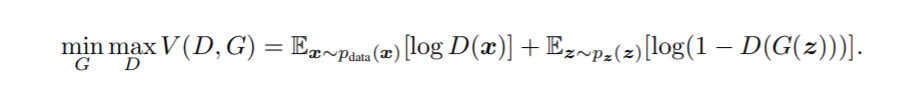

Generative model elinde sadece random noise varken discriminative model yardımıyla sihirli bir şekilde onu anlamlı bir veriye dönüştürüyor. Yukarıda gördüğümüz uzun formül işte o sihirli sözcükler. GANs'in nasıl çalıştığını anlamak için bu formülü anlamamız gerek, uzun bir formül fakat mantığı çok basit. Formül bizim loss fonksiyonumuz yani değerini olabildiğince düşürmek istiyoruz. Şimdi biz polisimizin sahte-gerçek ilişkisini daha iyi yapmasını istiyoruz. O zaman datamızdan gelen verileri doğru sınıflandırma olasılığının maksimum olmasını isteriz. Olasılık 0-1 arasında bir değerdir. İsteğimiz maksimum değerde loss fonksiyonumuzun düşük çıkmasını isteriz. Logaritmada log(1) değeri 0'a tekabül ettiğine göre tam ihtiyacımız olan fonksiyon.Eğer discriminative modelimiz data gerçek datadan beslendiği bu durumda datanın gerçek datadan kaynaklandığını tespit ederek 1'e yakın bir değer döndürürse log(D(x)) 0'a yaklaşır. İşte formülün birinci kısmının açıklaması. Formülün ikinci kısmında ise log(1 − D(G(z))) ifadesini görüyoruz. Burada noise olarak ifade ettiğimiz sentetik veriden kaynaklanan bir durum var. Yani generative modelimiz iyi iş yapmalı. Generative modelimizin iyi iş yaptığı durumda discriminative modelimiz verinin gerçek datadan gelme olasılığını veriyor ise D(G(z)) için G(z) değerini maksimize derek D(G(z)) değerini minimuma getiririz. D(G(z)) değeri 0' a yaklaştıkça  log(1 − D(G(z))) değeri de 0'a yaklaşır.İmplementasyonda Log(D(G(z)) değerini maksimize etmek bizim için hedefimiz olucak. Loss fonksiyonumuzu minimize etmiş oluruz. Sihirli sözcükleri basit bir şekilde bu bağlamda dile getirmiş oldum.


### Mantığı özetleyelim

Model G sahte veri üretmeye çalışır, model D ise kendisine gelen verilerin gerçek mi sahte mi olduğunu ayırt eder. Train sürecinde bahsi geçen loss fonksiyonunu düşürmeye çalışırken iki model de daha başarılı sonuç ortaya koyar. Yeteri kadar train ettiğimiz model sonuçta bize gerçekten ayıramayacağımız veriler sunar.

# GANs İmplementasyonu

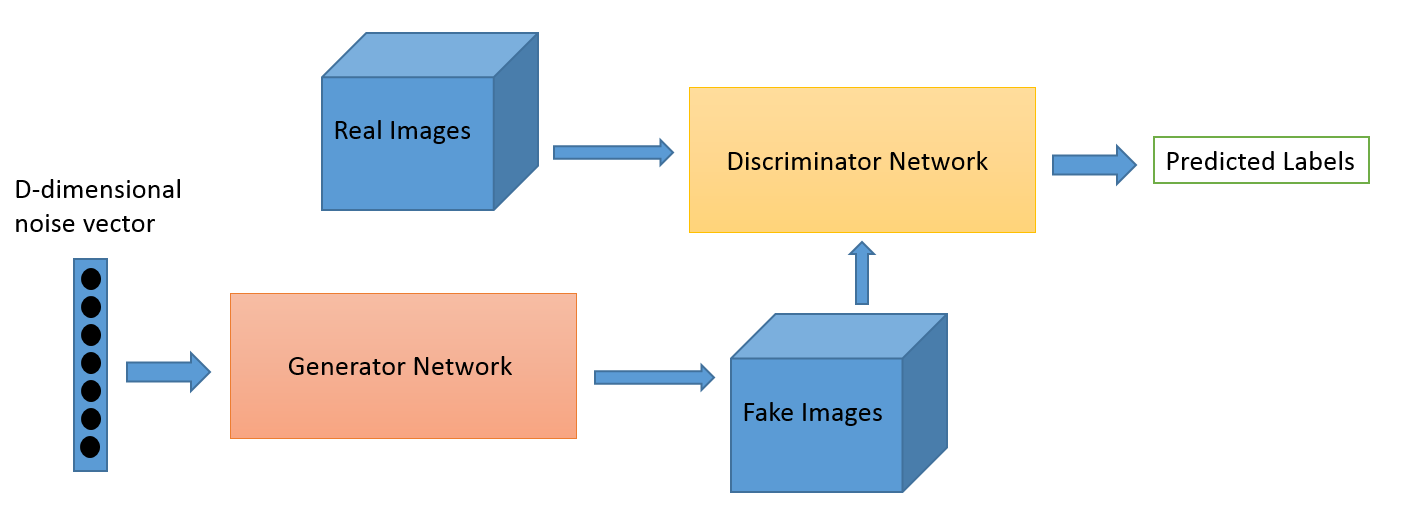

### DATA

Derin öğrenme denince akla ilk gelen dataset MNIST datasetini kullanacağız.

In [61]:
%matplotlib inline
import numpy as np # Matris işlemleri
import torch 
import matplotlib.pyplot as plt # Görselleştirme aracı
import torch.nn as nn # Neural network yapısında kullanılan yapıları yaratmamızı sağlar.
import torch.nn.functional as F # Neural network yapısında kullanılan yapıları yaratmamızı sağlar.
import torch.optim as optim # Optimizerları kullanmamıza yarar.
from torchvision import datasets # Datasetimizi indirmeye yarar.
import torchvision.transforms as transforms # Datamızı tenosrlere çevirmeye yarar
import pickle as pkl # generate ettiğimiz resimleri kaydetmeye yarar.


In [62]:
#num_workers train sürecinde modeli eğitirken forward ve backward propagation sırasında 
#datamızdan kaç batch'i GPU'ya taşıyacağının miktarıdır. Doğru rakam modelimizi hızlandırır.
num_workers = 1 # Deneyimlerim kendi GPU'm için en iyi sonucu 1'in verdiği yönünde
# Her bir batch'de kaç sample olacağını tanımlıyoruz.
batch_size = 64

# Paperda incelediğimizde datada herhangi bir transform işlemi uygulanmamış. 
#Sadece tensore dönüştürüyoruz ki modeli besleyebilelim.
transform = transforms.ToTensor()

# Datamızı indiriyoruz.
train_data = datasets.MNIST(root='data', train=True,
                                   download=True, transform=transform)

# prepare data loader
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           num_workers=num_workers,shuffle = True)

### Modellerimizi tanımlayalım.

### Discriminator

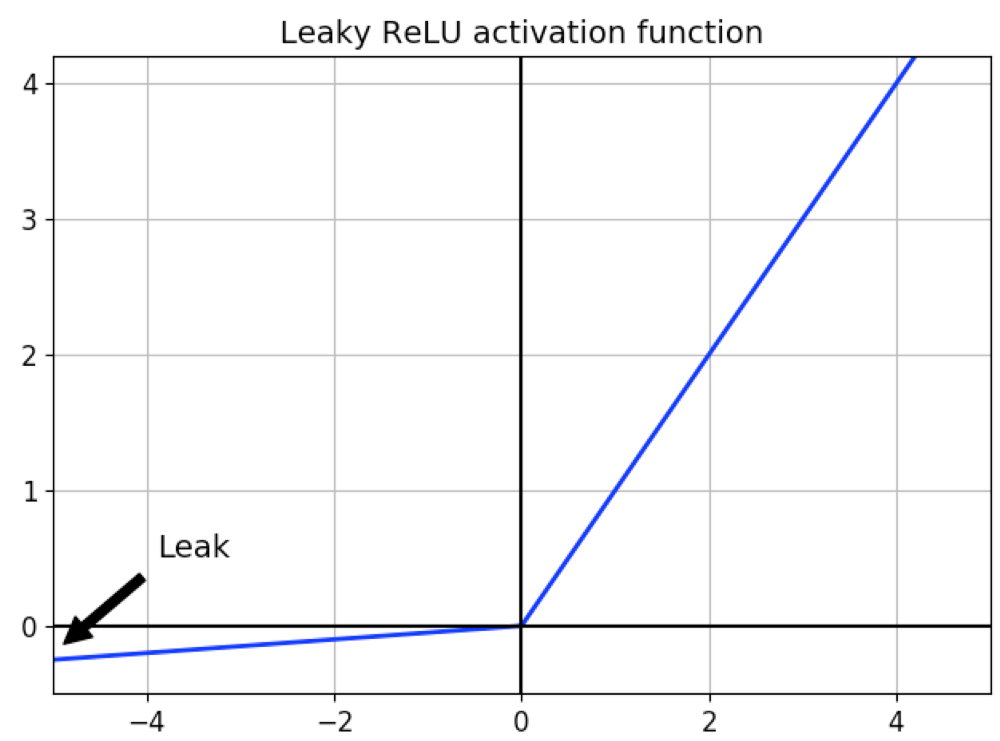

In [63]:
class Discriminator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Discriminator, self).__init__()
        
        # Hidden layerları tanımlayalım.
        self.fc1 = nn.Linear(input_size, hidden_dim*4)#input size = 28*28 (resmimizin boyutu,MNIST)
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)
        
        # Output verecek layerımız. Output size önemli. Modelimiz 0 ile 1 arasında bir olasılık döndürücek 
        #yani output_size değerimiz 1.
        self.fc4 = nn.Linear(hidden_dim, output_size)
        
        # dropout layer. Modelimizin stabil çalışması için önemli. 
        self.dropout = nn.Dropout(0.35)
        
        
    def forward(self, x):
        # modele vereceğimiz şekilde 784 değerini elde etmek için resme flatten (düzleştirme) uyguluyoruz.
        x = x.view(-1, 28*28)#
        # all hidden layers
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, eğim)  Leaky ReLU yukarıda resmedilmiştir. 
        #X değerlerinin eksi olduğu kısımdaki eğimi tanımladık
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        x = self.fc4(x)

        return x

### GENERATOR

In [64]:
class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim, output_size):
        super(Generator, self).__init__()
        
        # Hidden layerları tanımlayalım.
        self.fc1 = nn.Linear(input_size, hidden_dim)# input size'ımız random noise. Herhangi bir şey ifade etmiyor aslında.
        #İleride 100 olarak tanımlayacağız Goodfellow'un yaptığı gibi.
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        
        # Output değerimiz gene önemli. Burdaki çıktı discriminatora gidicek. Discriminatorın input sizeını
        # 28*28 tanımlamıştık datamızdaki resimlerin boyutu. Discriminatorın input değeri = Generatorun output değeri
        self.fc4 = nn.Linear(hidden_dim*4, output_size)
        
        # dropout layer . Generatorun ürettiği tüm sampleların 
        # tek bir noktaya evrilmemesi için overfittingi önlememiz için önemli
        self.dropout = nn.Dropout(0.35)

    def forward(self, x):
        
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, eğim)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        # DCGANs paperında output layerına aktivasyon fonksiyonu olarak tanh uyguladığını görebiliriz.
        # Tanh fonksiyonunun simetrik olması siyah beyaz dengesinde etkilidir diye çıkarım yaptım.
        # Aynı zamanda ReLU gibi bir aktivasyon fonksiyonu olsaydı değerlerimizin yarısı  tamamen siyah olabilirdi.
        x = torch.tanh(self.fc4(x))

        return x

### Model hyperparameters

In [65]:
# Discriminator hyperparams

input_size = 784 # 28*28

d_output_size = 1 # Olasılık değeri olduğu için 1

d_hidden_size = 32 # Hidden layerlardaki perceptron sayılarını kolay kontrol edebilmek için hyperparam olarak tanımladık.

# Generator hyperparams


z_size = 100 # Noise vektörünün boyutu

g_output_size = 784 # Generatorün çıktı boyutu.Discriminatorun girdi boyutu/ Üretmek istediğimiz resim boyutu/ Sampleların boyutu

g_hidden_size = 32 # Hidden layerlardaki perceptron sayılarını kolay kontrol edebilmek için hyperparam olarak tanımladık.

In [84]:
D = Discriminator(input_size, d_hidden_size, d_output_size)
G = Generator(z_size, g_hidden_size, g_output_size)


print(D)
print(G)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.35, inplace=False)
)
Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.35, inplace=False)
)


### Modellerin Loss Fonksiyonları

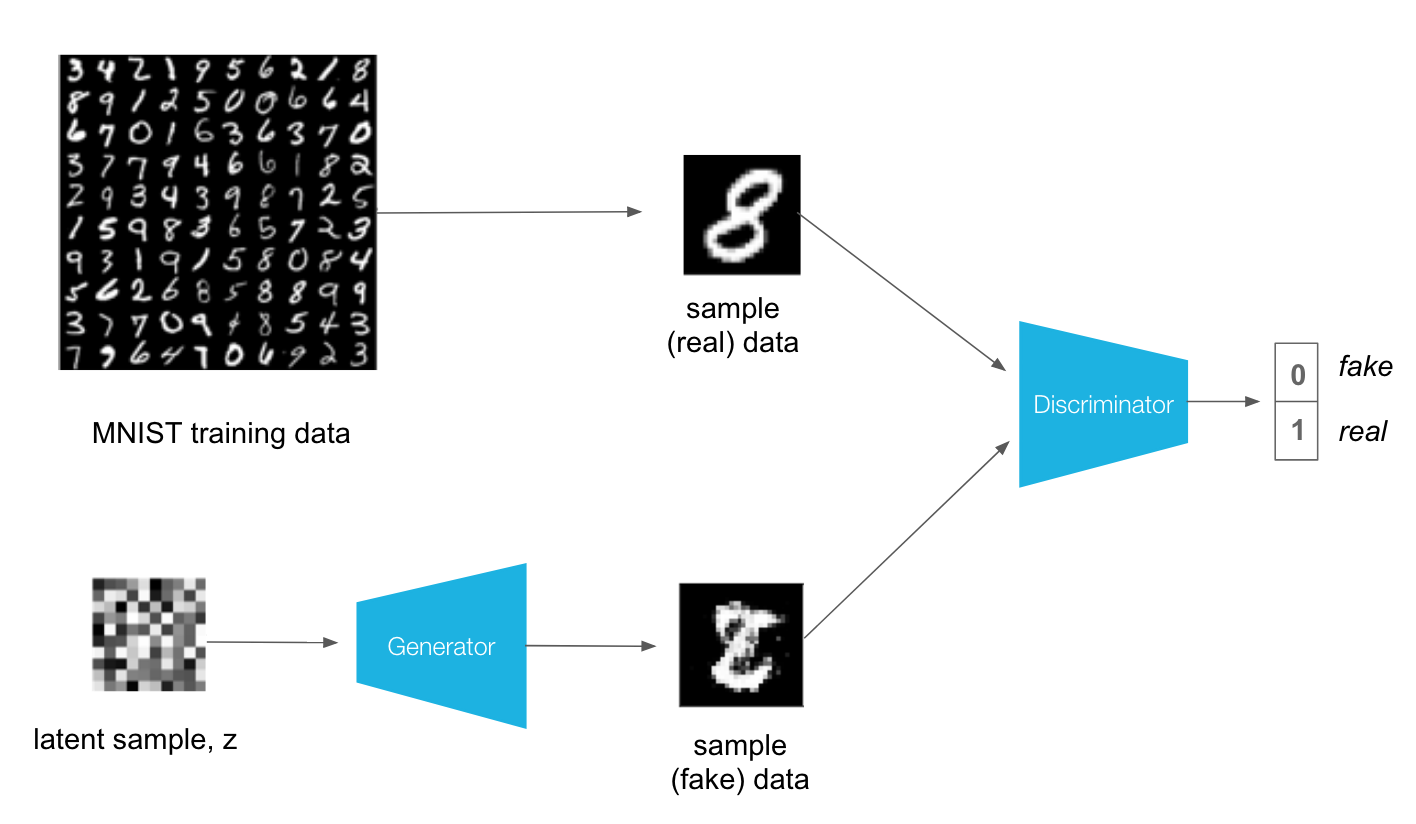

"Peki nasıl çalışıyor ?" Başlığı altında yeterli bir şekilde açıkladığımı düşünüyorum fakat kısaca açıklayacağım. Discriminator için d_loss = d_real_loss + d_fake_loss kullanacağız. Yukarıdaki resimde gözüktüğü üzere model D hem gerçek hem sahte resimleri sınıflandırarak eğitiliyor. Generator için de aynısı aslında fakat Discriminator iyi bir iş yapıyorsa generator yapmıyor demektir. O zaman labelları tam tersi şeklinde verirsek problem ortadan kalkar.

In [85]:
def real_loss(D_out, smooth=False):
    batch_size = D_out.size(0)
    # label smoothing
    if smooth:
        # model D'miz sınıflandırma yaparken kendine çok güvenmesin diye 1 olan label değerlerini 0.9 ile çarpalım.
        labels = (torch.ones(batch_size)*0.9)
    else:
        labels = torch.ones(batch_size) # real labels = 1
        
    # BCE lossu incelerseniz neden kullandığımızı anlayacaksınız. Withlogit kısmı olasılık değerleri ile uğraştığımız için
    # sigmoid fonksiyonu kullanarak 0-1 range arasında değerlendiriyoruz.
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

def fake_loss(D_out):
    batch_size = D_out.size(0)
    labels = torch.zeros(batch_size) # fake labels = 0
    criterion = nn.BCEWithLogitsLoss()
    # calculate loss
    loss = criterion(D_out.squeeze(), labels)
    return loss

### Optimizer

In [86]:
lr = 0.002 #Learning rate için 0.002'nin paperda (GANs,Goodfellow) başarılı bir değer olduğundan bahsediliyor.

# 2 modeli ayrı ayrı eğiteceğimiz için 2 farklı optimizer tanımlıyoruz. Paperda SGD kullandıklarını ifade ediyorlar fakat
# 2014'den bu yana çok şey değişti :)
d_optimizer = optim.Adam(D.parameters(), lr)
g_optimizer = optim.Adam(G.parameters(), lr)

### Training

In [87]:
# epoch sayısı
num_epochs = 50

samples = [] # ürettiğimiz resimleri depolamak için bir liste 
losses = [] # Lossları depoluyoruz.

print_every = 400 # Her iterasyonda bastırmaya gerek yok zaten ufak farklar oluşuyor.


sample_size=16
fixed_z = np.random.uniform(-1, 1, size=(sample_size, z_size)) # random noise olarak adlandırdığımız 
# generatoru besleyeceğimiz veri
fixed_z = torch.from_numpy(fixed_z).float()

# Modelleri train moduna alalım.
D.train()
G.train()
for epoch in range(num_epochs):
    
    for batch_i, (real_images, _) in enumerate(train_loader):
                
        batch_size = real_images.size(0)
        
        # Rescaling yapmamız gerek
        real_images = (real_images*2 - 1) #[0,1) to [-1, 1)
        
       
        #  TRAINING model DISCRIMINATOR
        
        
        d_optimizer.zero_grad()
        
        # 1.Gerçek resimler ile train

        D_real = D(real_images)
        d_real_loss = real_loss(D_real, smooth=True)
        
        # 2. Fake resimler ile train
        
        # fake resim üretelim.
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Forward prop yapıp lossumuzu hesaplayalım.        
        D_fake = D(fake_images)
        d_fake_loss = fake_loss(D_fake)
        
        # lossları toplayıp back prop yapalım.
        d_loss = d_real_loss + d_fake_loss
        d_loss.backward()
        d_optimizer.step()
        
        
       
        # TRAINING model GENERATOR
        
        g_optimizer.zero_grad()
        
        # Fake resimler ile eğitelim.
        
        # Fake resim (noise) üretelim.
        z = np.random.uniform(-1, 1, size=(batch_size, z_size))
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        # Fake resimler ile model D 'de sınıflandırma yapalım. 
        # Fake resimlerin lossunu hesaplayalım.
        D_fake = D(fake_images)
        g_loss = real_loss(D_fake) # use real loss to flip labels
        
        # backprop
        g_loss.backward()
        g_optimizer.step()

        # Lossları yazdıralım
        if batch_i % print_every == 0:
            # print discriminator and generator loss
            print('Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item()))

    
    #Lossları kaydedelim.
    losses.append((d_loss.item(), g_loss.item()))
    
    # Resim üretip kaydedelim.
    G.eval() # Eval Mode
    samples_z = G(fixed_z)
    samples.append(samples_z)
    G.train() # Train mode


# Resimleri locale kaydedelim.
with open('train_samples.pkl', 'wb') as f:
    pkl.dump(samples, f)

Epoch [    1/   50] | d_loss: 1.3966 | g_loss: 0.6560
Epoch [    1/   50] | d_loss: 1.2717 | g_loss: 1.2254
Epoch [    1/   50] | d_loss: 1.3018 | g_loss: 0.9825
Epoch [    2/   50] | d_loss: 1.5323 | g_loss: 0.7050
Epoch [    2/   50] | d_loss: 1.3488 | g_loss: 0.7919
Epoch [    2/   50] | d_loss: 1.0682 | g_loss: 1.1248
Epoch [    3/   50] | d_loss: 0.8378 | g_loss: 3.3642
Epoch [    3/   50] | d_loss: 1.3107 | g_loss: 0.7459
Epoch [    3/   50] | d_loss: 1.2629 | g_loss: 0.9779
Epoch [    4/   50] | d_loss: 1.4471 | g_loss: 1.1756
Epoch [    4/   50] | d_loss: 1.3126 | g_loss: 1.2804
Epoch [    4/   50] | d_loss: 0.9893 | g_loss: 1.5397
Epoch [    5/   50] | d_loss: 1.1915 | g_loss: 0.8273
Epoch [    5/   50] | d_loss: 1.1259 | g_loss: 1.2915
Epoch [    5/   50] | d_loss: 0.9645 | g_loss: 2.5624
Epoch [    6/   50] | d_loss: 1.0842 | g_loss: 2.2811
Epoch [    6/   50] | d_loss: 1.0115 | g_loss: 1.7707
Epoch [    6/   50] | d_loss: 1.1092 | g_loss: 1.9874
Epoch [    7/   50] | d_loss

Modelimizi locale kaydedelim.

In [91]:
model_g = torch.save(G.state_dict(), "model_g")
model_d = torch.save(D.state_dict(), "model_d")

Ürettiğimiz fake resimler gerçeğe yakın mı artık bakabiliriz.

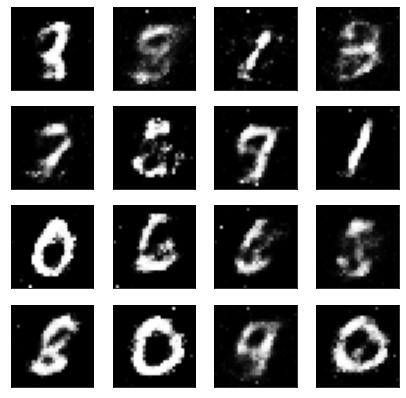

In [90]:
def view_samples(epoch, samples):
    fig, axes = plt.subplots(figsize=(7,7), nrows=4, ncols=4, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')

with open('train_samples.pkl', 'rb') as f:
    samples = pkl.load(f)

view_samples(-1, samples)